<a href="https://colab.research.google.com/github/VincentCsNv/SymbioseManagement/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install rasterio laspy lazrs --quiet
!pip install pdal --quiet



In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import laspy
from pathlib import Path
import glob 
import pandas as pd

In [15]:
DATA_dir = "data/"
repartition = { 'train': 0.8, 'val': 0.1, 'test': 0.1}
random_seed = 42

# 1. Getting data :

In [16]:
def rep_df_train_test_val(data_df, repartition, random_seed):
    """
    Splits the dataframe into training, validation, and test sets based on species.
    
    Parameters:
    - data_df: DataFrame containing the data with a 'species' column.
    - repartition: Dictionary with keys 'train', 'val', 'test' and their corresponding fractions.
    - random_seed: Seed for reproducibility.
    
    Returns:
    - data_df: DataFrame with an additional 'dataset' column indicating the split.
    """
    data_df["dataset"] = "None"
    for species in data_df['species'].unique():
        specie_df = data_df[data_df['species'] == species]
        specie_df_train = specie_df.sample(frac=repartition['train'], random_state=random_seed)
        specie_df_remaining = specie_df.drop(specie_df_train.index)
        specie_df_val = specie_df_remaining.sample(frac=repartition['val']/(repartition['val'] + repartition['test']), random_state=42)
        specie_df_test = specie_df_remaining.drop(specie_df_val.index)
        
        data_df.loc[specie_df_train.index, 'dataset'] = 'train'
        data_df.loc[specie_df_val.index, 'dataset'] = 'val'
        data_df.loc[specie_df_test.index, 'dataset'] = 'test'
    return data_df

def detailed_distribution(df):
    print("=" * 50)
    print("🌳 Sample by species:")
    species_counts = df['species'].value_counts()
    species_pct = (species_counts / len(df) * 100).round(1)
    for species, count in species_counts.items():
        pct = species_pct[species]
        print(f"  {species}: {count} samples ({pct}%)")
    
    print("\n" + "=" * 50)
   
    print("🎯 Dataset distribution:")
    dataset_counts = df['dataset'].value_counts()
    dataset_pct = (dataset_counts / len(df) * 100).round(1)
    for dataset, count in dataset_counts.items():
        pct = dataset_pct[dataset]
        print(f"  {dataset}: {count} samples ({pct}%)")
    
    print("\n" + "=" * 50)
    # Vérification des ratios attendus
    print("\n🔍 Detailed distribution:")
    pct_by_species = pd.crosstab(df['species'], df['dataset'], normalize='index') * 100
    expected = {'train': 80, 'val': 10, 'test': 10}  # ratios attendus
    
    for species in df['species'].unique():
        print(f"\n🌳 {species}:")
        species_pct = pct_by_species.loc[species]
        
        for dataset in ['train', 'val', 'test']:
            if dataset in species_pct.index:
                actual = species_pct[dataset]
                expected_val = expected[dataset]
                diff = abs(actual - expected_val)
                
                status = "✅" if diff < 2 else "⚠️" if diff < 5 else "❌"
                print(f"  {dataset:5}: {actual:5.1f}% (attendu: {expected_val}%) {status}")



In [17]:
#Getting all the files path
print("Getting all the files .tiff and .laz path...")
aerial_files = glob.glob(DATA_dir + "**/**/**/*.tiff")
lidar_files = glob.glob(DATA_dir + "**/**/**/*.laz")
files_path = aerial_files + lidar_files
print(f"Number of files : {len(files_path)}")

#Creating a dataframe with the files path and extracting metadata from the path
data_df = pd.DataFrame(files_path, columns=['path'])
data_df["species"] = data_df["path"].apply(lambda x: x.split("/")[-4])
data_df["type"] = data_df["path"].apply(lambda x: x.split("/")[-3])

# Creating training/validation/test split based on repartion part
data_df = rep_df_train_test_val(data_df, repartition, random_seed)
#data_df.head(2) #visualizing the dataframe

detailed_distribution(data_df[data_df["type"] == "imagery"]) #Visualization 


Getting all the files .tiff and .laz path...
Number of files : 17138
🌳 Sample by species:
  Picea_abies: 4074 samples (47.5%)
  Castanea_sativa: 3684 samples (43.0%)
  Abies_alba: 811 samples (9.5%)

🎯 Dataset distribution:
  train: 6885 samples (80.3%)
  val: 868 samples (10.1%)
  test: 816 samples (9.5%)


🔍 Detailed distribution:

🌳 Abies_alba:
  train:  81.4% (attendu: 80%) ✅
  val  :   9.6% (attendu: 10%) ✅
  test :   9.0% (attendu: 10%) ✅

🌳 Castanea_sativa:
  train:  80.1% (attendu: 80%) ✅
  val  :  10.2% (attendu: 10%) ✅
  test :   9.7% (attendu: 10%) ✅

🌳 Picea_abies:
  train:  80.4% (attendu: 80%) ✅
  val  :  10.2% (attendu: 10%) ✅
  test :   9.4% (attendu: 10%) ✅


In [18]:
img_path = data_df[(data_df["type"] == "imagery") & (data_df["dataset"] == "train")]["path"].values[10]
lidar_path = data_df[(data_df["type"] == "lidar") & (data_df["dataset"] == "train")]["path"].values[4]
print(f"Image path : {img_path}")
print(f"Lidar path : {lidar_path}")

Image path : data/Abies_alba/imagery/test/TEST-Abies_alba-C9-586_1_243.tiff
Lidar path : data/Abies_alba/lidar/test/TEST-Abies_alba-C9-586_1_223.laz


Image shape (bands, height, width): (4, 250, 250)


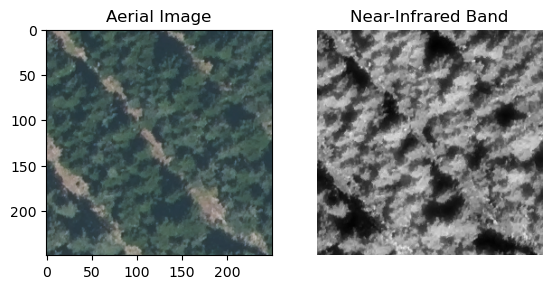

In [36]:
#open tiff RGB + near infrared images. 
with rasterio.open(img_path) as src:
    img = src.read()
    print(f"Image shape (bands, height, width): {img.shape}")
    plt.subplot(1, 2, 1)
    plt.imshow(np.moveaxis(img, 0, -1)[:,:,1:4])  # Move bands to the last dimension for visualization
    plt.title("Aerial Image")
    plt.subplot(1, 2, 2)    
    plt.imshow(np.moveaxis(img, 0, -1)[:,:,0], cmap='gray')  # Near-infrared band
    plt.title("Near-Infrared Band")
    plt.axis('off')

    plt.show()

In [21]:
# pylas peut avoir du mal avec LAZ sans lazrs
import numpy as np
import laspy

with laspy.open(lidar_path) as fh:
    print('Points from Header:', fh.header.point_count)
    las = fh.read()
    print(las)
    print('Points from data:', len(las.points))
    ground_pts = las.classification == 2
    bins, counts = np.unique(las.return_number[ground_pts], return_counts=True)
    print('Ground Point Return Number distribution:')
    for r,c in zip(bins,counts):
        print('    {}:{}'.format(r,c))

Points from Header: 113353
<LasData(1.4, point fmt: <PointFormat(8, 0 bytes of extra dims)>, 113353 points, 0 vlrs)>
Points from data: 113353
Ground Point Return Number distribution:
    1:12614
    2:7733
    3:4512
    4:984
    5:96


In [25]:
def inspect_las_attributes(las):
    """Montre TOUT ce qui est disponible dans ton fichier LAS"""
    
    print("🔍 INSPECTION COMPLÈTE DE TON OBJET LAS")
    print("="*60)
    
    # 1. ATTRIBUTS PRINCIPAUX TOUJOURS PRÉSENTS
    print("📍 COORDONNÉES (toujours présentes):")
    print(f"   las.x          → {len(las.x):,} points X")
    print(f"   las.y          → {len(las.y):,} points Y") 
    print(f"   las.z          → {len(las.z):,} points Z (altitude)")
    
    print("\n🔢 PROPRIÉTÉS DE BASE (toujours présentes):")
    print(f"   las.intensity           → Intensité du retour laser")
    print(f"   las.return_number       → Numéro du retour (1er, 2e, 3e...)")
    print(f"   las.number_of_returns   → Nombre total de retours pour ce pulse")
    print(f"   las.classification      → Classification des points")
    print(f"   las.scan_direction_flag → Direction de scan")
    print(f"   las.edge_of_flight_line → Bord de ligne de vol")
    print(f"   las.user_data          → Données utilisateur")
    print(f"   las.point_source_id    → ID de la source")
    
    # 2. VÉRIFICATION DES ATTRIBUTS OPTIONNELS
    print("\n🌈 COULEURS (optionnel - dépend du fichier):")
    if hasattr(las, 'red') and hasattr(las, 'green') and hasattr(las, 'blue'):
        print("   ✅ las.red    → Canal rouge RGB")
        print("   ✅ las.green  → Canal vert RGB")  
        print("   ✅ las.blue   → Canal bleu RGB")
        print(f"      Range RGB: R[{las.red.min()}-{las.red.max()}] G[{las.green.min()}-{las.green.max()}] B[{las.blue.min()}-{las.blue.max()}]")
    else:
        print("   ❌ Pas de couleurs RGB dans ce fichier")
    
    print("\n⏰ TEMPS (optionnel):")
    if hasattr(las, 'gps_time'):
        print(f"   ✅ las.gps_time → Temps GPS acquisition")
        print(f"      Range: [{las.gps_time.min():.2f}, {las.gps_time.max():.2f}]")
    else:
        print("   ❌ Pas de temps GPS dans ce fichier")
    
    print("\n📡 ANGLES DE SCAN (optionnel):")
    if hasattr(las, 'scan_angle_rank'):
        print(f"   ✅ las.scan_angle_rank → Angle de scan")
        print(f"      Range: [{las.scan_angle_rank.min()}, {las.scan_angle_rank.max()}]°")
    else:
        print("   ❌ Pas d'angle de scan dans ce fichier")
    
    # 3. DONNÉES ÉTENDUES (LAS format > 1.2)
    print("\n🔬 DONNÉES ÉTENDUES (dépend de la version LAS):")
    extended_attrs = ['nir', 'wave_packet_descriptor_index', 'byte_offset_to_waveform_data', 
                     'waveform_packet_size', 'return_point_waveform_location', 
                     'x_t', 'y_t', 'z_t']
    
    for attr in extended_attrs:
        if hasattr(las, attr):
            print(f"   ✅ las.{attr}")
        else:
            print(f"   ❌ las.{attr}")

# Lance l'inspection de TON fichier
inspect_las_attributes(las)


🔍 INSPECTION COMPLÈTE DE TON OBJET LAS
📍 COORDONNÉES (toujours présentes):
   las.x          → 113,353 points X
   las.y          → 113,353 points Y
   las.z          → 113,353 points Z (altitude)

🔢 PROPRIÉTÉS DE BASE (toujours présentes):
   las.intensity           → Intensité du retour laser
   las.return_number       → Numéro du retour (1er, 2e, 3e...)
   las.number_of_returns   → Nombre total de retours pour ce pulse
   las.classification      → Classification des points
   las.scan_direction_flag → Direction de scan
   las.edge_of_flight_line → Bord de ligne de vol
   las.user_data          → Données utilisateur
   las.point_source_id    → ID de la source

🌈 COULEURS (optionnel - dépend du fichier):
   ✅ las.red    → Canal rouge RGB
   ✅ las.green  → Canal vert RGB
   ✅ las.blue   → Canal bleu RGB
      Range RGB: R[0-51200] G[0-50944] B[0-49152]

⏰ TEMPS (optionnel):
   ✅ las.gps_time → Temps GPS acquisition
      Range: [311077053.65, 311078299.76]

📡 ANGLES DE SCAN (optionnel)

In [31]:
np.unique(las.classification)

array([2, 3, 4, 5], dtype=uint8)

🎯 COORDONNÉES CHARGÉES :
📊 X: 754200.0 → 754250.0 m
📊 Y: 6403750.0 → 6403800.0 m
📊 Z: 1253.5 → 1274.6 m

🌲 ANALYSE VERTICALE :
🏔️  Hauteur max: 1274.6 m
🌱 Hauteur min: 1253.5 m
📏 Amplitude: 21.0 m


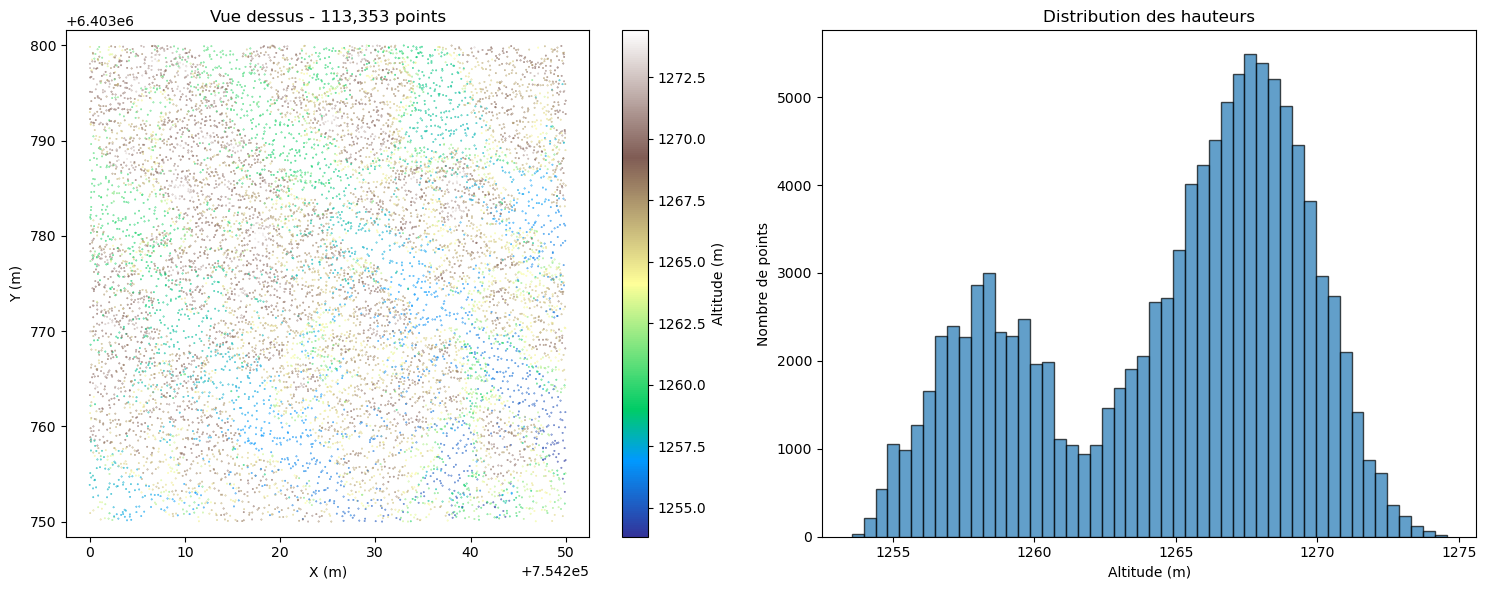


🏷️ CLASSIFICATION :
🌱 Sol: 25,939 points
🌲 Végétation: 86,116 points
🔍 Autres: 1,298 points


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Extraire les coordonnées
x, y, z = las.x, las.y, las.z

print(f"🎯 COORDONNÉES CHARGÉES :")
print(f"📊 X: {x.min():.1f} → {x.max():.1f} m")
print(f"📊 Y: {y.min():.1f} → {y.max():.1f} m") 
print(f"📊 Z: {z.min():.1f} → {z.max():.1f} m")

# Statistiques par hauteur
print(f"\n🌲 ANALYSE VERTICALE :")
print(f"🏔️  Hauteur max: {z.max():.1f} m")
print(f"🌱 Hauteur min: {z.min():.1f} m")
print(f"📏 Amplitude: {z.max()-z.min():.1f} m")

# Visualisation rapide
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Vue du dessus (X,Y colorée par Z)
scatter = ax1.scatter(x[::10], y[::10], c=z[::10], s=0.1, cmap='terrain')
ax1.set_title(f'Vue dessus - {len(x):,} points')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
plt.colorbar(scatter, ax=ax1, label='Altitude (m)')
ax1.axis('equal')

# Histogramme des hauteurs
ax2.hist(z, bins=50, alpha=0.7, edgecolor='black')
ax2.set_title('Distribution des hauteurs')
ax2.set_xlabel('Altitude (m)')
ax2.set_ylabel('Nombre de points')

plt.tight_layout()
plt.show()

# Points de sol vs végétation
ground_mask = las.classification == 2
vegetation_mask = las.classification == 5

print(f"\n🏷️ CLASSIFICATION :")
print(f"🌱 Sol: {np.sum(ground_mask):,} points")
print(f"🌲 Végétation: {np.sum(vegetation_mask):,} points") 
print(f"🔍 Autres: {len(las.points) - np.sum(ground_mask) - np.sum(vegetation_mask):,} points")


In [24]:
las

<LasData(1.4, point fmt: <PointFormat(8, 0 bytes of extra dims)>, 113353 points, 0 vlrs)>

🎯 INPUT MODÈLE: (51, 51, 3)


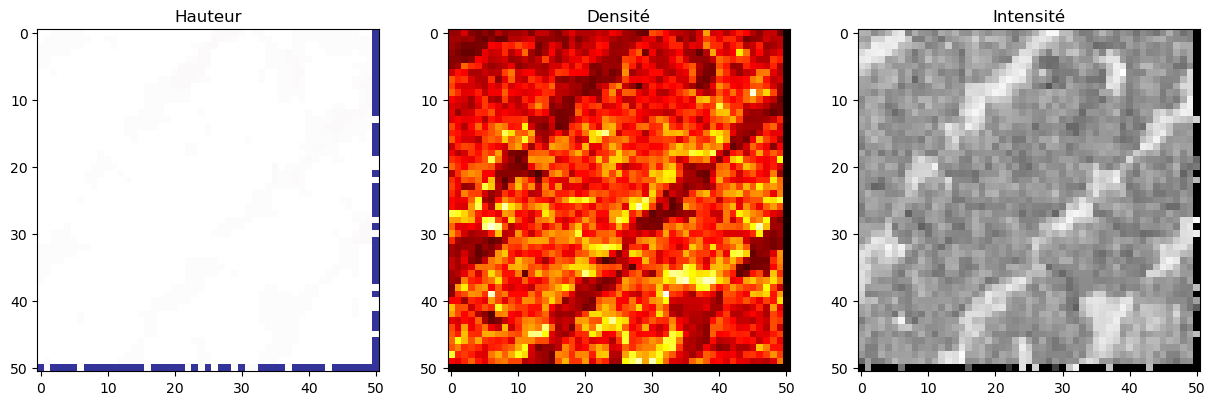

NameError: name 'torch' is not defined

In [23]:
def points_to_heightmap(x, y, z, resolution=1.0):
    """Projette en carte de hauteur (comme une image)"""
    
    # Grille 2D
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    
    nx = int((x_max - x_min) / resolution) + 1
    ny = int((y_max - y_min) / resolution) + 1
    
    # Images multicouches
    height_map = np.full((ny, nx), -999.0)      # hauteur max
    density_map = np.zeros((ny, nx))            # densité
    intensity_map = np.zeros((ny, nx))          # intensité moyenne
    
    for i in range(len(x)):
        px = int((x[i] - x_min) / resolution)
        py = int((y[i] - y_min) / resolution)
        
        if 0 <= px < nx and 0 <= py < ny:
            # Hauteur maximum par pixel
            height_map[py, px] = max(height_map[py, px], z[i])
            density_map[py, px] += 1
            if hasattr(las, 'intensity'):
                intensity_map[py, px] += las.intensity[i]
    
    # Normaliser intensité
    mask = density_map > 0
    intensity_map[mask] = intensity_map[mask] / density_map[mask]
    
    # Stack comme image RGB
    pseudo_image = np.stack([
        height_map,
        density_map, 
        intensity_map
    ], axis=-1)  # (H, W, 3)
    
    return pseudo_image

# Ton input devient une "pseudo-image"
heightmap_input = points_to_heightmap(x, y, z, resolution=1.0)
print(f"🎯 INPUT MODÈLE: {heightmap_input.shape}")

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(heightmap_input[:,:,0], cmap='terrain')
axes[0].set_title('Hauteur')
axes[1].imshow(heightmap_input[:,:,1], cmap='hot') 
axes[1].set_title('Densité')
axes[2].imshow(heightmap_input[:,:,2], cmap='gray')
axes[2].set_title('Intensité')
plt.show()

# Pour CNN 2D (comme ResNet)
tensor_2d = torch.from_numpy(heightmap_input.transpose(2,0,1)).float()  # (3, H, W)
